### imports

In [1]:
import json
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tictactoe.board import Board

### Generate Data

In [2]:
size = 3
boards = {}
def generate_data(board):
    b = Board()
    if np.array2string(board.flatten()) not in list(boards.keys()):
        out_boards = []
        for i,j in b.get_best_moves(board):
            nb = Board()
            nb.set_board(np.copy(board))
            nb.place(i,j)
            out_boards.append(nb.to_str())
        boards[np.array2string(board.flatten())] = out_boards

    for i, j in list(zip(*np.where(board==0))):
        nb = Board()
        nb.set_board(np.copy(board))
        nb.place(i,j)
        new_board = nb.board
        try:
            generate_data(new_board)
        except:
            print(f"i: {i} j: {j} board:{new_board}")
            raise
generate_data(np.array([[0,0,0],
                        [0,0,0],
                        [0,0,0]]))

#### Save data

In [6]:
fixed_data = {k:v for k, v in boards.items() if v != []}
with open('./data/data.json', 'w') as f:
    json.dump(fixed_data, f, indent=4)

### Split Data

In [8]:
with open('./data/data.json', 'r') as f:
    data = json.load(f)

In [9]:
train_percent, val_percent, test_percent = 0.7, 0.2, 0.1

data_keys = list(data.keys())
n = len(data_keys)
num_train, num_val, num_test = int(train_percent*n), int(val_percent*n), int(test_percent*n)

select_train = random.sample(data_keys, num_train)
val_and_test = [value for value in data_keys if value not in select_train]

select_val = random.sample(val_and_test, num_val)
select_test = [value for value in val_and_test if value not in select_val]

In [10]:
def boards_to_format(key):
    key = key[1:-1]
    return [int(c) for c in key.split(' ') if c in ['-1', '0', '1']]

train_data = {int(i): (boards_to_format(k), [boards_to_format(v) for v in data[k]]) for i, k in enumerate(select_train)}
val_data = {int(i): (boards_to_format(k), [boards_to_format(v) for v in data[k]]) for i, k in enumerate(select_val)}
test_data = {int(i): (boards_to_format(k), [boards_to_format(v) for v in data[k]]) for i, k in enumerate(select_test)}

In [11]:
print(f"Amount train: {len(list(train_data.keys()))}")
print(f"Amount val: {len(list(val_data.keys()))}")
print(f"Amount test: {len(list(test_data.keys()))}")

Amount train: 4144
Amount val: 1184
Amount test: 592


#### Save the Data

In [12]:
with open('./data/train.json', 'w') as f:
    json.dump(train_data, f)
with open('./data/val.json', 'w') as f:
    json.dump(val_data, f)
with open('./data/test.json', 'w') as f:
    json.dump(test_data, f)

### Load Data

In [2]:
class TicTacDataset(Dataset):
    def __init__(self, path = './data/train.json'):
        with open(path, 'r') as f:
            self.data = json.load(f)
        self.len = len(list(self.data.keys()))
        
    def __len__(self,):
        return self.len
    
    def __getitem__(self, idx):
        ins, outs = self.data[str(idx)]
        return ins, outs

In [3]:
train_dataset = TicTacDataset(path='./data/train.json')
val_dataset = TicTacDataset(path='./data/val.json')
test_dataset = TicTacDataset(path='./data/test.json')

In [4]:
def collate(batch):
    ins = [torch.tensor(b[0])+1 for b in batch]
    outs = [torch.tensor(b[1][0])+1 for b in batch]
    return torch.stack(ins), torch.stack(outs)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)

### Create Model

In [5]:
class Head(nn.Module):
    """ Singular Head"""

    def __init__(self,
                 num_embedding,
                 head_size,
                 dropout
                 ):
        super().__init__()
        self.key = nn.Linear(num_embedding, head_size, bias=False)
        self.query = nn.Linear(num_embedding, head_size, bias=False)
        self.value = nn.Linear(num_embedding, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape

        k = self.key(x) # (B,T,C)
        q = self.query(x) # (B,T,C)

        # Computer attention
        # C**0.5 is to make the numbers smaller so softmax doesn't do weird things
        wei = q @ k.transpose(-2, -1) / C**0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # 
        V = self.value(x)
        out = wei @ V # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out
    
class MultiHeadAttention(nn.Module):
    """Multiple Attention Heads"""
    def __init__(self, num_heads, num_embedding, head_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(num_embedding, head_size, dropout) for i in range(num_heads)])
        self.project = nn.Linear(num_embedding, num_embedding)                  # Projection layer for gettting back into the residual pathway
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.project(out)
        out = self.dropout(out)
        return out
    
class FeedFoward(nn.Module):
    """Single Layer"""

    def __init__(self, num_embedding, dropout):
        super().__init__()

        self.m = nn.Sequential(nn.Linear(num_embedding, 4 * num_embedding), # 4* because they did it in the paper
                               nn.ReLU(),
                               nn.Linear(4 * num_embedding, num_embedding), # Projection layer for gettting back into the residual pathway
                               nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.m(x)
    
class Block(nn.Module):
    """"""

    def __init__(self, num_embedding, num_heads, dropout):
        super().__init__()

        head_size = num_embedding // num_heads
        self.self_attn = MultiHeadAttention(num_heads, num_embedding, head_size, dropout)
        self.feed_fwd = FeedFoward(num_embedding, dropout)

        self.lay_norm1 = nn.LayerNorm(num_embedding)
        self.lay_norm2 = nn.LayerNorm(num_embedding)

    def forward(self, x):
        x = x + self.self_attn(self.lay_norm1(x))
        x = x + self.feed_fwd(self.lay_norm2(x))
        return x
    
class TicTacToeModel(nn.Module):
    def __init__(self,
                 vocab_size,
                 block_size,
                 num_embedding,
                 num_heads,
                 num_blocks,
                 dropout,
                ):
        super().__init__()

        # Embeddings
        self.token_embedding_table = nn.Embedding(vocab_size,num_embedding)
        self.position_embedding_table = nn.Embedding(block_size, num_embedding)

        # Attention
        self.attn_blocks = nn.Sequential(
            *[Block(num_embedding, num_heads, dropout) for i in range(num_blocks)],
            nn.LayerNorm(num_embedding),
        )

        self.lm_head = nn.Linear(num_embedding, vocab_size)

    def forward(self, inputs):
        B, T = inputs.shape

        token_embedding = self.token_embedding_table(inputs) # (B, T, C)
        position_embedding = self.position_embedding_table(torch.arange(T)) # (T, C)
        x = token_embedding + position_embedding # (B, T, C)

        x = self.attn_blocks(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
            
        return logits


### Create Trainer

In [13]:
class ModelTrainer:
    def __init__(self, model,
                 train_dataloader,
                 val_dataloader, 
                 lr=1e-3,
                 epochs = 100,
                 early_stopping = 100,
                 device = None):
        self.verbose = False

        self.model = model
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')

        self.model.to(self.device)

        self.train_loader = train_dataloader
        self.val_loader = val_dataloader

        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=self.lr)
        self.criterion = nn.CrossEntropyLoss() 
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                                    mode='min',
                                                                    factor = 0.5,
                                                                    patience = 30)  # Reduce LR when learning stops

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        
        for inputs, labels in tqdm(self.train_loader, desc="Training", unit="batch"):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()  # Zero the gradients
            logits = self.model(inputs)
            
            loss = self.criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            loss.backward()  # Backpropagate the loss
            self.optimizer.step()  # Update model parameters
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(self.train_loader)
        return avg_train_loss
    
    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        
        with torch.no_grad():  # No need to track gradients during evaluation
            for inputs, labels in self.val_loader: #tqdm(self.val_loader, desc="Evaluating", unit="batch"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                logits = self.model(inputs)
                outputs = torch.argmax(logits, dim=2)
                
                loss = self.criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
                running_loss += loss.item()
                
                total += labels.size(0)
                correct += (torch.all(outputs == labels, dim=1)).sum().item()
        
        avg_val_loss = running_loss / len(self.val_loader)
        accuracy = correct / total
        return avg_val_loss, accuracy
    
    def train(self):
        best_val_loss = np.inf
        train_losses = []
        val_losses = []
        
        for epoch in range(self.epochs):
            # print(f"Epoch {epoch+1}/{self.epochs}")
            train_loss = self.train_one_epoch()
            val_loss, val_accuracy = self.evaluate()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            if self.verbose:
                print(f"Train Loss: {train_loss:.4f}")
                print(f"Validation Loss: {val_loss:.4f}")
                print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
            
            # Save the best model based on validation accuracy
            if val_loss < best_val_loss:
                counter = 0
                best_val_loss = val_loss
                print("Saving best model...")
                torch.save(self.model.state_dict(), "./models/best_model.pth")
            else:
                counter += 1

            if counter > 50:
                print(f"Early stopping at Epoch {epoch}")
                break
        return train_losses, val_losses


    def load_best_model(self):
        self.model.load_state_dict(torch.load("./models/best_model.pth"))
        self.model.to(self.device)
        print("Best model loaded successfully.")

    def test(self, test_dataloader, model_path: str = None):
        if model_path is None:
            self.load_best_model()
        else:
            self.model.load_state_dict(torch.load(model_path))
            self.model.to(self.device)

        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():  # No need to track gradients during evaluation
            for inputs, labels in tqdm(test_dataloader, desc="Testing", unit="batch"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                logits = self.model(inputs)
                
                
                outputs = torch.argmax(logits, dim=2)
                # print(f"outputs shape: {outputs.shape}")
                
                total += labels.size(0)
                correct += (torch.all(outputs == labels, dim=1)).sum().item()
                # input()
        
        accuracy = correct / total
        return accuracy
        

### Train Model

In [14]:
model = TicTacToeModel(vocab_size = 3,
                       num_embedding = 128,
                       num_heads = 8,
                       num_blocks = 4,
                       block_size = 9,
                       dropout = 0.1
                       )
trainer = ModelTrainer(model, train_dataloader, val_dataloader, epochs=500)

In [15]:
train_loss, val_loss = trainer.train()

Training: 100%|██████████| 65/65 [00:06<00:00, 10.52batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:06<00:00, 10.12batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.39batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.25batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:06<00:00, 10.45batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.07batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.45batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.89batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 12.17batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.48batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.72batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.76batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.42batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.59batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.60batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.54batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.72batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.86batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.87batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:06<00:00, 10.62batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:06<00:00, 10.64batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.62batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.51batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.63batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.64batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.88batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.71batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.74batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 12.01batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.82batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.72batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.56batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.63batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.57batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.70batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.51batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.88batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 12.01batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.67batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.63batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.75batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.94batch/s]


Saving best model...


Training: 100%|██████████| 65/65 [00:05<00:00, 11.69batch/s]


Early stopping at Epoch 270


In [16]:
def plot_losses(train_losses, val_losses):
    """
    Plots training and validation losses over epochs.

    Parameters:
    - train_losses: List of training loss values (one per epoch).
    - val_losses: List of validation loss values (one per epoch).
    """
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label="Training Loss", marker='o', linestyle='-', color='blue')
    plt.plot(val_losses, label="Validation Loss", marker='s', linestyle='--', color='orange')
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./references/models/exp4/losses.png")
    
    plt.show()

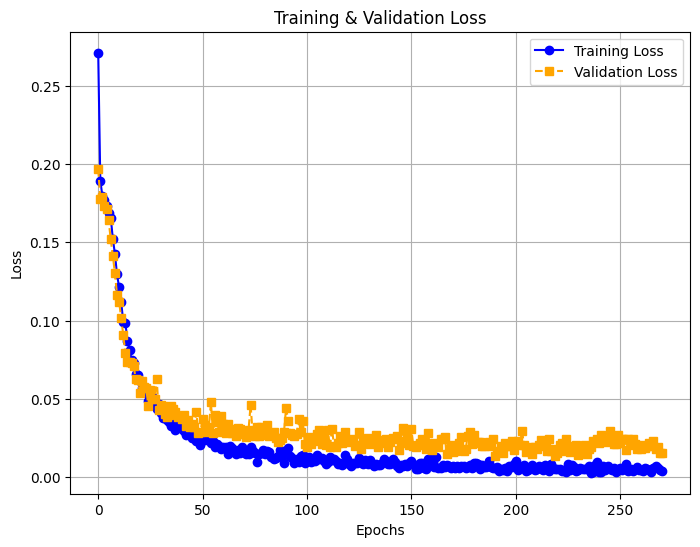

In [17]:
plot_losses(train_loss, val_loss)

In [18]:
trainer.verbose = True
trainer.test(test_dataloader)

Best model loaded successfully.


Testing: 100%|██████████| 10/10 [00:00<00:00, 43.14batch/s]


0.9662162162162162

### Testing

#### Exp 1

In [21]:
model = TicTacToeModel(vocab_size = 3,
                       num_embedding = 32,
                       num_heads = 4,
                       num_blocks = 4,
                       block_size = 9,
                       dropout = 0.0
                       )
trainer = ModelTrainer(model, train_dataloader, val_dataloader, epochs=500)
trainer.test(test_dataloader, model_path="./models/exp1/best_model.pth")

Testing: 100%|██████████| 10/10 [00:00<00:00, 80.42batch/s]


0.8445945945945946

#### Exp 2

In [22]:
model = TicTacToeModel(vocab_size = 3,
                       num_embedding = 32,
                       num_heads = 4,
                       num_blocks = 4,
                       block_size = 9,
                       dropout = 0.0
                       )
trainer = ModelTrainer(model, train_dataloader, val_dataloader, epochs=500)
trainer.test(test_dataloader, model_path="./models/exp2/best_model.pth")

Testing: 100%|██████████| 10/10 [00:00<00:00, 66.38batch/s]


0.9222972972972973

#### Exp 3

In [23]:
model = TicTacToeModel(vocab_size = 3,
                       num_embedding = 32,
                       num_heads = 8,
                       num_blocks = 4,
                       block_size = 9,
                       dropout = 0.0
                       )
trainer = ModelTrainer(model, train_dataloader, val_dataloader, epochs=500)
trainer.test(test_dataloader, model_path="./models/exp3/best_model.pth")

Testing: 100%|██████████| 10/10 [00:00<00:00, 50.81batch/s]


0.9493243243243243

#### Exp 4

In [25]:
model = TicTacToeModel(vocab_size = 3,
                       num_embedding = 128,
                       num_heads = 8,
                       num_blocks = 4,
                       block_size = 9,
                       dropout = 0.0
                       )
trainer = ModelTrainer(model, train_dataloader, val_dataloader, epochs=500)
trainer.test(test_dataloader, model_path="./models/exp4/best_model.pth")

Testing: 100%|██████████| 10/10 [00:00<00:00, 40.66batch/s]


0.9662162162162162